# Algorithmus für künstliche Intelligenz mit CNN

## Libaray

In [1]:
import os
import glob
import time

import numpy as np
import random

import optuna

import torch
from torch import nn
import torch.optim as optim

from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torch.utils.data import Dataset

import torchvision.models as models
from torchvision.models import ResNet50_Weights

from scipy import signal

import matplotlib.pyplot as plt



In [2]:
torch.set_float32_matmul_precision("high")

## Modell auf der GPU ausführen

In [3]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


## Modell Name

In [4]:
model_name = "cnn_model_V3.pt"

## Einlesen der Daten

In [5]:
class Load_Data:
    
    def __init__(self, root_dir = ""):
        
        self.root_dir = root_dir
        
        self.signal_list_all = []
        self.lable_list_all = []
        
        self.signal_list_80 = []
        self.signal_list_20 = []
        self.lable_list_80 = []
        self.lable_list_20 = []
        
        self.width_w = np.arange(1, 127)
        
        self.load_data()
        self.sort_data()

    def load_data(self):
        
        for dirpath, dirnames, filenames in os.walk(self.root_dir):
            for filename in filenames:
                if filename.endswith('.npz'): 
                    
                    file_path = os.path.join(dirpath, filename)
                    data = np.load(file_path)
                    
                    frame_buffer = data['frame']
                    
                    max_val  = np.argmax(frame_buffer)
                    max_indices = np.unravel_index(max_val, frame_buffer.shape)[0]
                    #print(f"max_val {max_val}, max_indices: {max_indices}")
                    
                    if(max_indices < 13):
                        max_indices = 14
                        
                    if(max_indices > 17):
                        max_indices = 16
                        
                    signal_r = frame_buffer[max_indices,:]

                    #signal_r = data['signal']
                    #signal_full = signal_[np.newaxis] # An additional dimension is needed for later processing
                    signal_a = signal_r[::]  # Halving of the input data and thus of the features
                    
                    heart_rate = data['heart_uart']
                    respiration_rate = data['respiration_radar']
                    
                    heart_rate_t = heart_rate
                    respiration_rate_t = respiration_rate
                    signal_t = signal_a
   
                    self.lable_list_all.append([heart_rate_t, respiration_rate_t])
                    self.signal_list_all.append(signal_t)
    
    def sort_data(self):   
        
        lable = np.array(self.lable_list_all)
        signal_a = np.array(self.signal_list_all)

        unique_elements, counts_elements = np.unique(lable[:,0], return_counts=True)
        
        print(counts_elements)
        print(unique_elements)
        
        for element in unique_elements:
            
            total_count = counts_elements[np.where(unique_elements == element)]
            
            count_80 = int(total_count * 0.8)
            
            arr_l_80, arr_l_20 = np.split(lable[(lable[:,0] == element)], [count_80])
            arr_s_80, arr_s_20 = np.split(signal_a[(lable[:,0] == element)], [count_80])

            for count in range(len(arr_l_80)):
                self.lable_list_80.append(arr_l_80[count])
                
            for count in range(len(arr_l_20)):   
                self.lable_list_20.append(arr_l_20[count])
                
            for count in range(len(arr_l_80)):
               
                cwtmatr80_c = signal.cwt(arr_s_80[count], signal.ricker, self.width_w, dtype="complex64")
                cwtmatr80_r = np.absolute(cwtmatr80_c)
                self.signal_list_80.append(cwtmatr80_r)
                
            for count in range(len(arr_l_20)):   
                cwtmatr20_c = signal.cwt(arr_s_20[count], signal.ricker, self.width_w, dtype="complex64")
                cwtmatr20_r = np.absolute(cwtmatr20_c)
                self.signal_list_20.append(cwtmatr20_r)     
                
    def get_dataset_80(self):   
        return self.signal_list_80, self.lable_list_80
        
    def get_dataset_20(self):   
        return self.signal_list_20, self.lable_list_20
    

In [6]:
class MyDataset(Dataset):
    
    def __init__(self, signal_list, lable_list):

        self.lable_list_ = lable_list
        self.signal_list_ = signal_list
        self.lable_list = []
        self.signal_list = []
        
        self.append_data()

    def append_data(self):
        
        lable = np.array(self.lable_list_)
        signal = np.array(self.signal_list_)

        lable_ = torch.from_numpy(lable).float().to(device)
        signal_ = torch.from_numpy(signal).float().to(device)
        
        for value in lable_:
            self.lable_list.append(value)
            
        for value in signal_:
            self.signal_list.append(value)

    def __len__(self):
        

        return len(self.lable_list) // 2

    def __getitem__(self, idx):

        return self.signal_list[idx], self.lable_list[idx]
    

In [7]:
root_folder_train = "data"

dataset = Load_Data(root_folder_train)

[  4  49  25  27  53  48  34  66  86 144  96  90 122 199 231 234 257 209
 220 106 223 221 157 120 207 167 118 131  71  76 113  19  10   9   9   7
   2]
[56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79
 80 81 82 83 84 85 86 87 88 89 90 91 92]


In [8]:
signal_list_80, lable_list_80 = dataset.get_dataset_80()

dataset_train = MyDataset(signal_list_80, lable_list_80)

In [9]:
signal_list_20, lable_list_20 = dataset.get_dataset_20()

dataset_test = MyDataset(signal_list_20, lable_list_20)

In [10]:

dataloader_train = DataLoader(dataset_train, batch_size=32, shuffle=True)


0
torch.Size([32, 126, 1500])
torch.Size([32, 2])
tensor([67.,  6.], device='cuda:0')


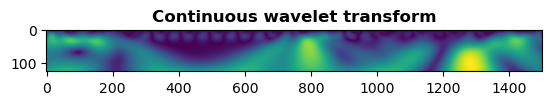

In [11]:

for i_batch, (inputs, targets) in enumerate(dataloader_train):

    print(i_batch)
    print(inputs.shape)
    print(targets.shape)
    print(targets[0,:])

    test_wavelet = inputs[0,:,:].cpu()
    
    plt.imshow(test_wavelet)
    plt.title("Continuous wavelet transform", fontweight ="bold")
    plt.savefig("CWT_train.png")  
    plt.show()

    break
    
    

In [12]:

dataloader_test = DataLoader(dataset_test, batch_size=32, shuffle=True)


0
torch.Size([32, 126, 1500])
torch.Size([32, 2])
tensor([59., 14.], device='cuda:0')


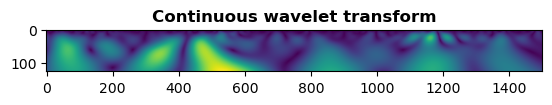

In [13]:

for i_batch, (inputs, targets) in enumerate(dataloader_test):
    
    print(i_batch)
    print(inputs.shape)
    print(targets.shape)
    print(targets[0,:])

    test_wavelet = inputs[0,:,:].cpu()
    
    plt.imshow(test_wavelet)
    plt.title("Continuous wavelet transform", fontweight ="bold")
    plt.savefig("CWT_test.png")  
    plt.show()

    break
    

## Einlesen der Daten

In [14]:

resnet50 = models.resnet50(weights=ResNet50_Weights.DEFAULT)

resnet50.conv1 = nn.Conv2d(inputs.shape[1], 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

num_ftrs = resnet50.fc.in_features

resnet50.fc = nn.Linear(num_ftrs, 1)


## Modellinstanz erstellen

In [15]:

criterion = nn.MSELoss()

optimizer = torch.optim.Adam(resnet50.parameters(), lr=0.001)

dateipfad = model_name

if os.path.isfile(dateipfad):
    print("Die Datei existiert.")
    resnet50.load_state_dict(torch.load(model_name))
    
resnet50 = resnet50.to(device)


In [16]:

epochs = 1000


In [17]:

def objective(trial):
    
    start_time = time.time()

    for epoch in range(epochs):  

        train_loss = 0.0

        resnet50.train()

        for i_batch, (inputs, targets) in enumerate(dataloader_train):

            inputs, targets = inputs.to(device), targets.to(device)
            inputs = inputs.unsqueeze(-1)
            optimizer.zero_grad()

            outputs = resnet50(inputs)
            loss = criterion(outputs, targets[:,0:1])
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss = train_loss / len(dataloader_train)

        valid_loss = 0

        resnet50.eval()

        with torch.no_grad():

            for i_batch, (inputs, targets) in enumerate(dataloader_test):

                inputs, targets = inputs.to(device), targets.to(device)

                inputs = inputs.unsqueeze(-1)  

                outputs = resnet50(inputs)
                loss = criterion(outputs, targets[:,0:1])
                valid_loss += loss.item()

        valid_loss = valid_loss / len(dataloader_test)

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Train Loss: {train_loss:.4f}, Val Loss: {valid_loss:.4f}')
            
        if (epoch + 1) % 1000 == 0:
            torch.save(resnet50.state_dict(), model_name)
            
        if (epoch + 1) % 100 == 0:
            print(f'predictions [{outputs.cpu().numpy()[0]}], targets: {targets[:,0:1].cpu().numpy()[0]}')
            
    end_time = time.time()

    execution_time = end_time - start_time
    
    print("Die Ausführungszeit beträgt: ", execution_time, " Sekunden")
    
    return valid_loss


In [18]:

loss = objective(0)


Epoch [10/1000], Train Loss: 15.1796, Val Loss: 37.2060
Epoch [20/1000], Train Loss: 11.4991, Val Loss: 33.4949
Epoch [30/1000], Train Loss: 12.5012, Val Loss: 30.1501
Epoch [40/1000], Train Loss: 13.4476, Val Loss: 24.9889
Epoch [50/1000], Train Loss: 11.7623, Val Loss: 25.7069
Epoch [60/1000], Train Loss: 10.6331, Val Loss: 30.9773
Epoch [70/1000], Train Loss: 10.7902, Val Loss: 39.9605
Epoch [80/1000], Train Loss: 10.9185, Val Loss: 22.0055
Epoch [90/1000], Train Loss: 14.8073, Val Loss: 26.0417
Epoch [100/1000], Train Loss: 12.1842, Val Loss: 27.2513
predictions [[64.39317]], targets: [73.]
Epoch [110/1000], Train Loss: 12.4407, Val Loss: 23.3969
Epoch [120/1000], Train Loss: 13.8378, Val Loss: 33.8061
Epoch [130/1000], Train Loss: 10.4711, Val Loss: 17.9467
Epoch [140/1000], Train Loss: 12.3782, Val Loss: 17.5918
Epoch [150/1000], Train Loss: 13.2182, Val Loss: 27.4047
Epoch [160/1000], Train Loss: 10.8027, Val Loss: 29.9995
Epoch [170/1000], Train Loss: 11.8224, Val Loss: 25.6502

KeyboardInterrupt: 

In [ ]:

print(loss)
